In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from dataset import load_system
from func import *

import gurobipy as gp
from gurobipy import GRB, tuplelist

In [2]:
# Write your inputs here.
casestr = 'case9'
T = 1 # Timestep for the simulation. For now, only available for one time step and further will be updated for multiple time steps
slackbus = [1] # Slack bus. Usually at bus 1 (might vary among test cases)

In [3]:
# Load the parameters of the system
net = load_system(casestr)
MVAbase = net.MVAbase
gen = net.gen
bus = net.bus
line = net.line

In [4]:
# Build tuplelists for the sets
set_t = list(range(T)) # Please dont make in in range(x) format. It should be list or np.arrays

nGen = gen.shape[0]
set_gen = gen.index
gen_t = tuplelist([(i,t) for t in set_t for i in set_gen])

nBus = bus.shape[0]
set_bus = bus.index
bus_t = tuplelist([(i,t) for t in set_t for i in set_bus])

nLine = line.shape[0]
set_line = line.index
line_t = tuplelist([(i,j,t) for t in set_t for i,j in set_line])

In [5]:
## Power Flow Variables
# For now, it is limited for the systems with single cable between two buses. It will throw an error for double transmission line (e.g. case 24_rts, 54, 118, 300) due to the naming of the indices.
m = gp.Model('casestr')
p_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=gen.Pmin.tolist()*len(set_t), ub=gen.Pmax.tolist()*len(set_t), name='P_Gen') # Generator active power
p_inj = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='P_Inj') # Bus injection
theta = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-math.pi, ub=math.pi, name='Theta') # Bus phase angle
p_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=[-i for i in line.rateA]*len(set_t), ub=line.rateA.tolist()*len(set_t), name='P_Line') # Line active power flow. The lower bound cannot be directly negated (or *(-1))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-25


In [6]:
# Power Flow Constraints
P_balance = m.addConstrs((p_ij.sum(i,'*',t) - p_ij.sum('*',i,t) == p_inj[i,t] for i,t in bus_t), name='P-Balance') # Constraint (1)

P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) - bus.loc[(i),'Pd'] for i,t in bus_t), name='P-Injection') # Constraint (2)

Angle_diff = m.addConstrs((p_ij[i,j,t] == perB(line,i,j) * (theta[i,t] - theta[j,t]) for i,j,t in line_t), name='Angle-Diff') # Constraint (3)

Slack_angle = m.addConstrs((theta[j,t] == 0 for j in slackbus for t in set_t), name='Slack-Angle') # Constraint (4)

In [7]:
m.setObjective(gp.quicksum(gen.loc[j,'a'] * (p_g[j,t]*MVAbase)**2 for j,t in gen_t) + gp.quicksum(gen.loc[j,'b'] * (p_g[j,t]*MVAbase) + gen.loc[j,'c'] for j,t in gen_t),GRB.MINIMIZE) # Objective function

In [8]:
m.update()
csname = casestr + '-DCOPF.lp'
m.write(csname)
m.Params.LogToConsole = 0 # Display the optimization progress

In [9]:
m.optimize()

In [10]:
print('The optimization converges in {} seconds'.format(m.Runtime))
print('with the optimal objective value of {}'.format(m.ObjVal))

The optimization converges in 0.002000093460083008 seconds
with the optimal objective value of 5216.026607747273


In [11]:
# Get the variable values
Pline = var_values(p_ij,MVAbase)
Theta = var_values(theta,180/math.pi)
Gen = var_values(p_g,MVAbase)

In [12]:
# Convert to dataframe to save the eyesight
Pline_res = pd.DataFrame({'P_flow': Pline},index=line.index)
Theta_res = pd.DataFrame({'Phase angle':Theta},index=bus.index)
Gen_res = pd.DataFrame({'Generated power':Gen},index=gen.index)
# Pline_res, Theta_res, Gen_res

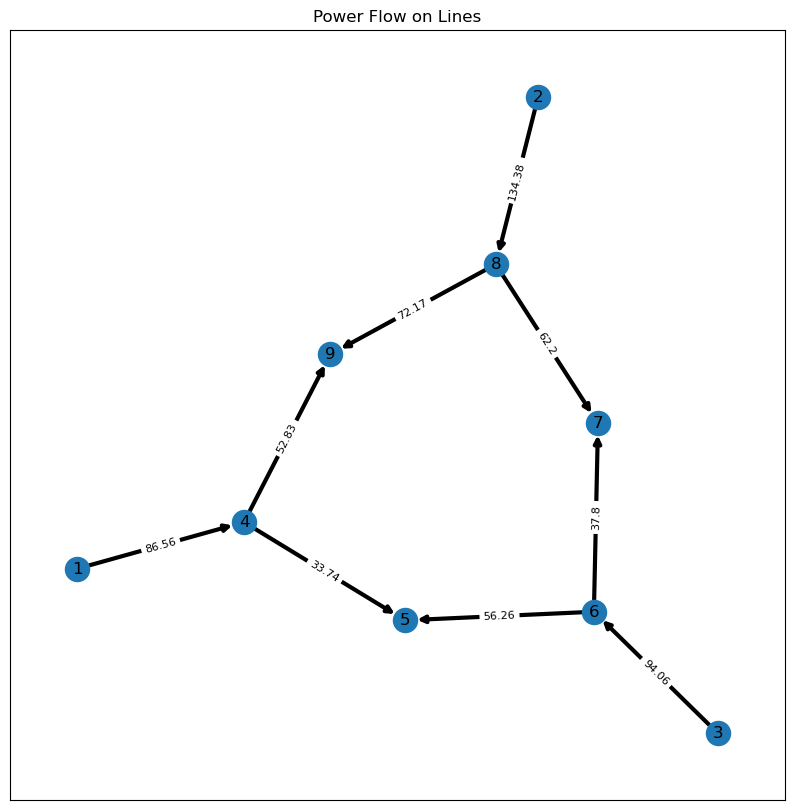

In [13]:
lineflow_plot(line, Pline)